In [200]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [201]:
merged_df=pd.read_csv("merged_dataset_final.csv")

In [202]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

In [203]:
merged_df=merged_df.dropna()

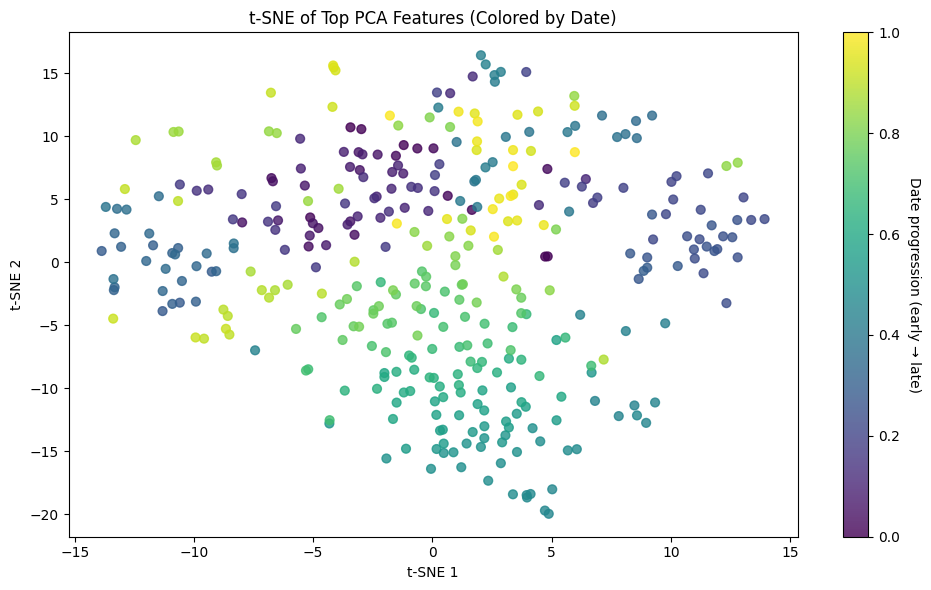

In [204]:

# -----------------------------
# Step 1: Clean & prepare data
# -----------------------------
df = merged_df.copy()

# Keep only numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# If original merged_df had a Date column, reuse it here
dates = pd.to_datetime(merged_df['Date'])

# Drop rows with NaNs in numeric data (to avoid t-SNE errors)
mask = df_numeric.dropna(axis=0, how='any').index
df_numeric = df_numeric.loc[mask]
dates = dates.loc[mask]

# -----------------------------
# Step 2: Standardize features
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# -----------------------------
# Step 3: Run t-SNE
# -----------------------------
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='random',
    random_state=42
)
X_embedded = tsne.fit_transform(X_scaled)

# -----------------------------
# Step 4: Create t-SNE DataFrame
# -----------------------------
tsne_df = pd.DataFrame({
    'TSNE1': X_embedded[:, 0],
    'TSNE2': X_embedded[:, 1],
    'Date': dates.values
}).sort_values('Date')

# Normalize date for color mapping
date_numeric = (tsne_df['Date'] - tsne_df['Date'].min()) / (
    tsne_df['Date'].max() - tsne_df['Date'].min()
)

# -----------------------------
# Step 5: Plot
# -----------------------------
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    tsne_df['TSNE1'],
    tsne_df['TSNE2'],
    c=date_numeric,
    cmap='viridis',
    s=40,
    alpha=0.8
)
cbar = plt.colorbar(scatter)
cbar.set_label('Date progression (early → late)', rotation=270, labelpad=15)
plt.title('t-SNE of Top PCA Features (Colored by Date)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()


In [205]:

# -------------------------
# 1️⃣ Define feature groups
# -------------------------
groups = {
    "Output_Income": [
        'RPI','W875RX1','INDPRO','IPFPNSS','IPFINAL','IPCONGD','IPDCONGD',
        'IPNCONGD','IPBUSEQ','IPMAT','IPDMAT','IPNMAT','IPMANSICS','IPB51222S',
        'IPFUELS','NAPMPI','CUMFNS'
    ],
    
    "Labor_Market": [
        'HWI','HWIURATIO','CLF16OV','CE16OV','UNRATE','UEMPMEAN','UEMPLT5',
        'UEMP5TO14','UEMP15OV','UEMP15T26','UEMP27OV','CLAIMSx','PAYEMS',
        'USGOOD','CES1021000001','USCONS','MANEMP','DMANEMP','NDMANEMP',
        'SRVPRD','USTPU','USWTRADE','USTRADE','USFIRE','USGOVT',
        'CES0600000007','AWOTMAN','AWHMAN','NAPMEI','CES0600000008',
        'CES2000000008','CES3000000008'
    ],
    
    "Consumption_Orders": [
        'HOUST','HOUSTNE','HOUSTMW','HOUSTS','HOUSTW','PERMIT','PERMITNE',
        'PERMITMW','PERMITS','PERMITW'
    ],
    
    "Orders_Inventories": [
        'DPCERA3M086SBEA','CMRMTSPLx','RETAILx','NAPM','NAPMNOI','NAPMSDI',
        'NAPMII','ACOGNO','AMDMNOx','ANDENOx','AMDMUOx','BUSINVx','ISRATIOx',
        'UMCSENTx'
    ],
    
    "Money_Credit": [
        'M1SL','M2SL','M2REAL','AMBSL','TOTRESNS','NONBORRES','BUSLOANS',
        'REALLN','NONREVSL','CONSPI','MZMSL','DTCOLNVHFNM','DTCTHFNM',
        'INVEST',"BOGMBASE"
    ],
    
    "Interest_Exchange": [
        'FEDFUNDS','CP3Mx','TB3MS','TB6MS','GS1','GS5','GS10','AAA','BAA',
        'COMPAPFFx','TB3SMFFM','TB6SMFFM','T1YFFM','T5YFFM','T10YFFM',
        'AAAFFM','BAAFFM','TWEXMMTH','EXSZUSx','EXJPUSx','EXUSUKx','EXCAUSx'
    ],
    
    "Prices": [
        'PPIFGS','PPIFCG','PPIITM','PPICRM','OILPRICEx','PPICMM','NAPMPRI',
        'CPIAUCSL','CPIAPPSL','CPITRNSL','CPIMEDSL','CUSR0000SAC','CUUR0000SAD',
        'CUSR0000SAS','CPIULFSL','CUUR0000SA0L2','CUSR0000SA0L5',
        'PCEPI','DDURRG3M086SBEA','DNDGRG3M086SBEA','DSERRG3M086SBEA','TWEXAFEGSMTHx','WPSFD49207','WPSFD49502','WPSID61','WPSID62','CUSR0000SAD','CUSR0000SA0L2',
    "CUSR0000SA0L2",
    ],
    
    "Stock_Market": [
        'S&P 500','S&P: indust','S&P div yield','S&P PE ratio'
    ]
}

## Correlation Pruning

In [206]:
def correlation_pruning(df, groups, threshold=0.9):
    """
    Performs correlation-based pruning within each feature group.

    Parameters
    ----------
    df : pd.DataFrame
        Full feature DataFrame.
    groups : dict
        Dictionary mapping group names to feature lists.
    threshold : float
        Correlation threshold above which one of two correlated columns is dropped.

    Returns
    -------
    pruned_df : pd.DataFrame
        DataFrame after dropping correlated columns.
    dropped_summary : dict
        Dictionary {group_name: [dropped_columns]}.
    """
    pruned_df = df.copy()
    dropped_summary = {}

    for group_name, cols in groups.items():
        existing = [c for c in cols if c in pruned_df.columns]
        if len(existing) < 2:
            continue  # Skip groups with <2 columns

        corr = pruned_df[existing].corr().abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

        if to_drop:
            dropped_summary[group_name] = to_drop
            pruned_df = pruned_df.drop(columns=to_drop, errors='ignore')

    # Print summary
    print("=== Correlation Pruning Summary ===")
    for g, dropped in dropped_summary.items():
        print(f"\nGroup: {g}")
        print(f"Dropped ({len(dropped)}): {dropped}")

    print("\n✅ Pruning complete.")
    return pruned_df, dropped_summary


# Example usage
pruned_df, dropped_cols = correlation_pruning(merged_df, groups, threshold=0.8)

=== Correlation Pruning Summary ===

Group: Output_Income
Dropped (9): ['IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD', 'IPBUSEQ', 'IPMAT', 'IPDMAT', 'IPMANSICS', 'CUMFNS']

Group: Labor_Market
Dropped (15): ['HWIURATIO', 'CE16OV', 'UNRATE', 'UEMP15T26', 'PAYEMS', 'USGOOD', 'USCONS', 'MANEMP', 'DMANEMP', 'NDMANEMP', 'SRVPRD', 'USTPU', 'USWTRADE', 'USTRADE', 'AWHMAN']

Group: Consumption_Orders
Dropped (9): ['HOUSTNE', 'HOUSTMW', 'HOUSTS', 'HOUSTW', 'PERMIT', 'PERMITNE', 'PERMITMW', 'PERMITS', 'PERMITW']

Group: Orders_Inventories
Dropped (4): ['CMRMTSPLx', 'RETAILx', 'ANDENOx', 'ISRATIOx']

Group: Interest_Exchange
Dropped (10): ['TB6MS', 'GS1', 'GS10', 'AAA', 'BAA', 'TB6SMFFM', 'T1YFFM', 'T10YFFM', 'AAAFFM', 'BAAFFM']

Group: Prices
Dropped (10): ['CPITRNSL', 'CUSR0000SAC', 'CPIULFSL', 'CUSR0000SA0L5', 'PCEPI', 'DNDGRG3M086SBEA', 'WPSFD49502', 'WPSID61', 'CUSR0000SA0L2', 'CUSR0000SA0L2']

✅ Pruning complete.


In [207]:
pruned_df.columns

Index(['Date', 'RPI', 'W875RX1', 'DPCERA3M086SBEA', 'INDPRO', 'IPNCONGD',
       'IPNMAT', 'IPB51222S', 'IPFUELS', 'HWI', 'CLF16OV', 'UEMPMEAN',
       'UEMPLT5', 'UEMP5TO14', 'UEMP15OV', 'UEMP27OV', 'CLAIMSx',
       'CES1021000001', 'USFIRE', 'USGOVT', 'CES0600000007', 'AWOTMAN',
       'HOUST', 'ACOGNO', 'AMDMNOx', 'AMDMUOx', 'BUSINVx', 'M1SL', 'M2SL',
       'M2REAL', 'BOGMBASE', 'TOTRESNS', 'NONBORRES', 'BUSLOANS', 'REALLN',
       'NONREVSL', 'CONSPI', 'S&P div yield', 'S&P PE ratio', 'FEDFUNDS',
       'CP3Mx', 'TB3MS', 'GS5', 'COMPAPFFx', 'TB3SMFFM', 'T5YFFM',
       'TWEXAFEGSMTHx', 'EXSZUSx', 'EXJPUSx', 'EXUSUKx', 'EXCAUSx',
       'WPSFD49207', 'WPSID62', 'OILPRICEx', 'PPICMM', 'CPIAUCSL', 'CPIAPPSL',
       'CPIMEDSL', 'CUSR0000SAD', 'CUSR0000SAS', 'DDURRG3M086SBEA',
       'DSERRG3M086SBEA', 'CES0600000008', 'CES2000000008', 'CES3000000008',
       'UMCSENTx', 'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST', 'VIXCLSx',
       'Policy Expectations - US', 'Macro Expectations - US', 'GDP

In [208]:
# -----------------------------------------------------------
# Function: Plot principal components for each macro group
# -----------------------------------------------------------
def plot_group_pca(df, groups, n_components=3):
    """
    For each group:
      - Standardizes the features
      - Runs PCA
      - Plots the top principal components' time series and explained variance
    """
    for name, cols in groups.items():
        existing = [c for c in cols if c in df.columns]
        if not existing:
            print(f"⚠️ Skipping {name}: no matching columns found.")
            continue

        X = df[existing].copy()
        X = X.fillna(X.mean())  # mean imputation to avoid dropna

        # Standardize
        X_scaled = StandardScaler().fit_transform(X)

        # PCA
        n_comps = min(n_components, len(existing))
        pca = PCA(n_components=n_comps, random_state=42)
        scores = pca.fit_transform(X_scaled)
        explained = pca.explained_variance_ratio_

        # -------------------------------
        # Plot (1) PCA time series
        # -------------------------------
        plt.figure(figsize=(10, 4))
        for i in range(n_comps):
            plt.plot(df.index, scores[:, i], label=f"PC{i+1} ({explained[i]*100:.1f}%)")
        plt.title(f"{name}: Principal Components")
        plt.xlabel("Date" if "Date" in df.columns else "Time index")
        plt.ylabel("Standardized Score")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        # -------------------------------
        # Plot (2) Explained variance bar
        # -------------------------------
        plt.figure(figsize=(5, 3))
        plt.bar(range(1, n_comps + 1), explained * 100, color='skyblue')
        plt.title(f"{name}: Explained Variance by PC")
        plt.xlabel("Principal Component")
        plt.ylabel("Variance Explained (%)")
        plt.grid(alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()


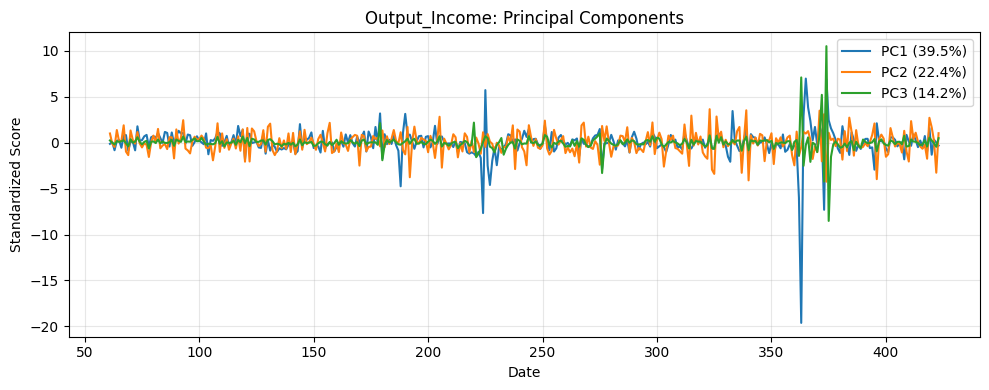

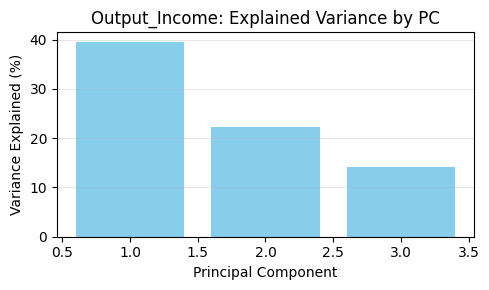

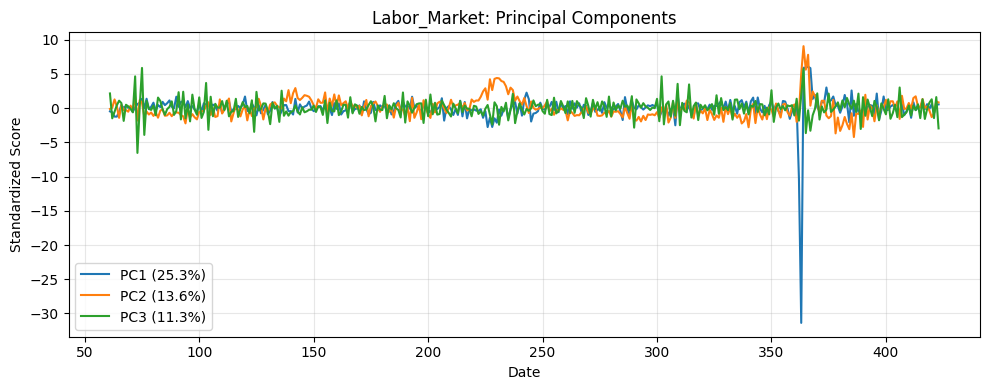

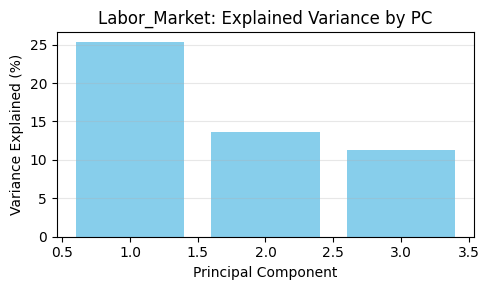

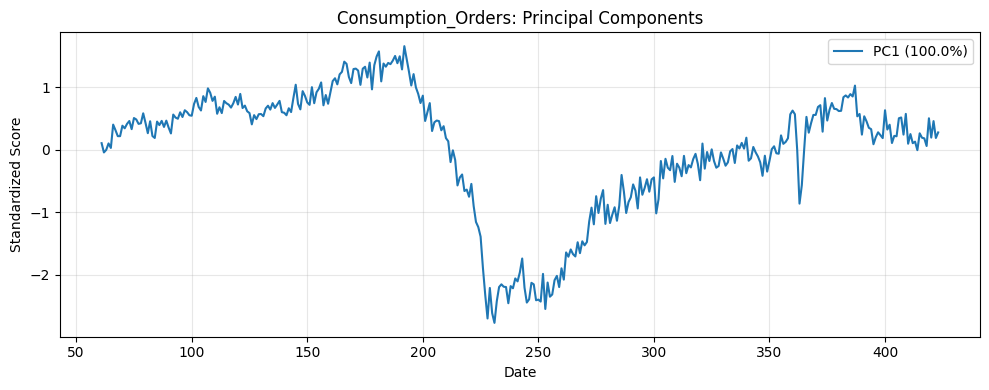

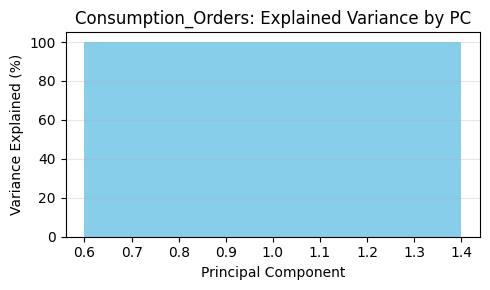

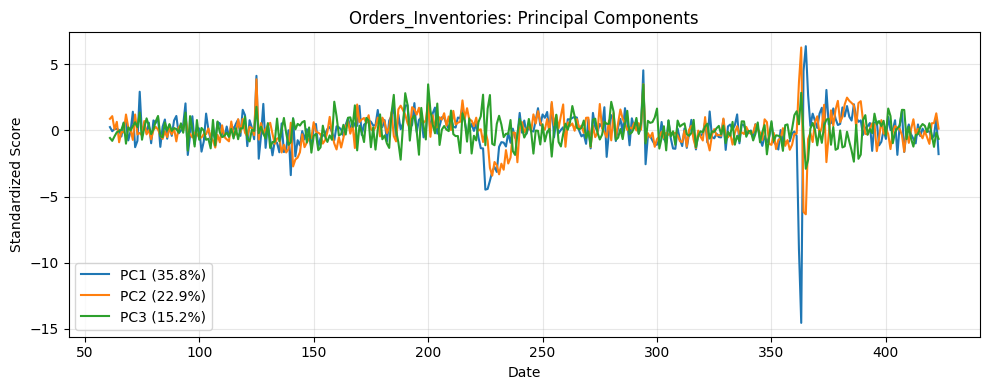

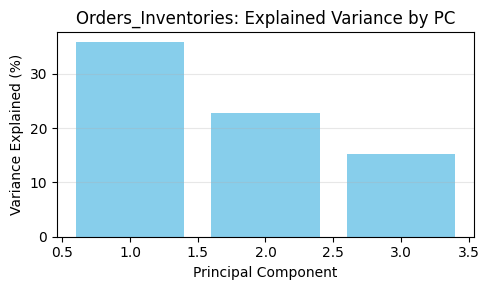

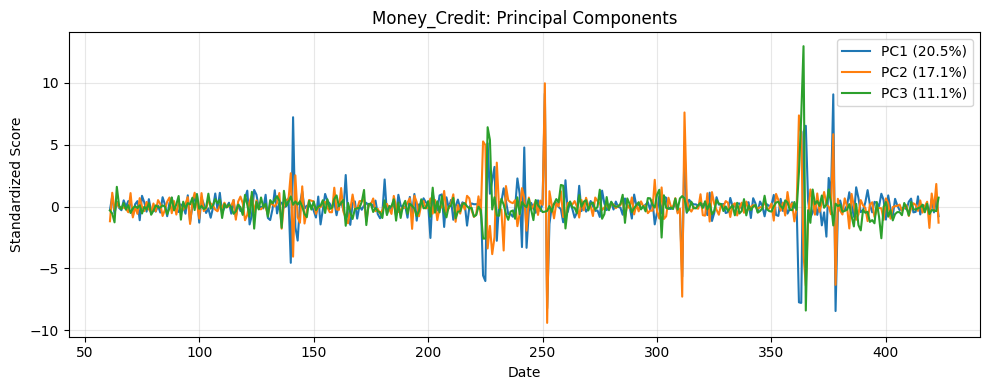

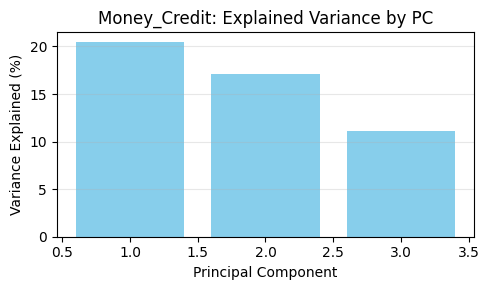

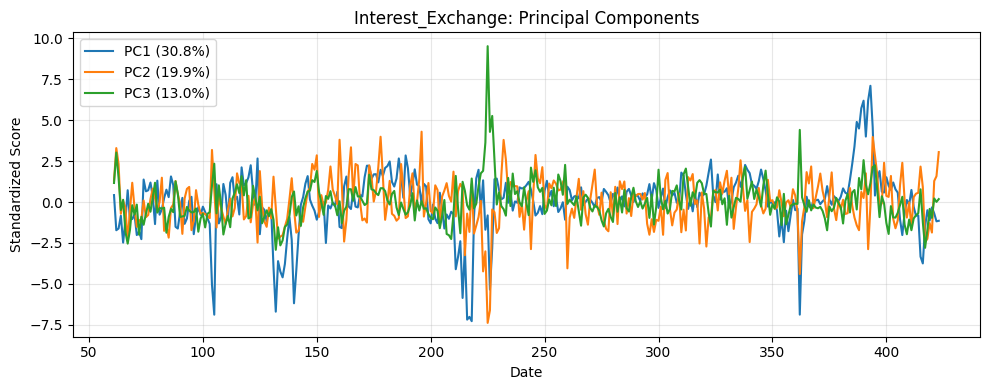

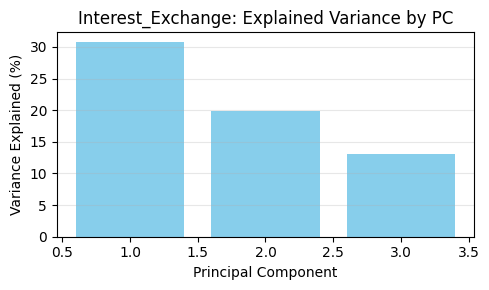

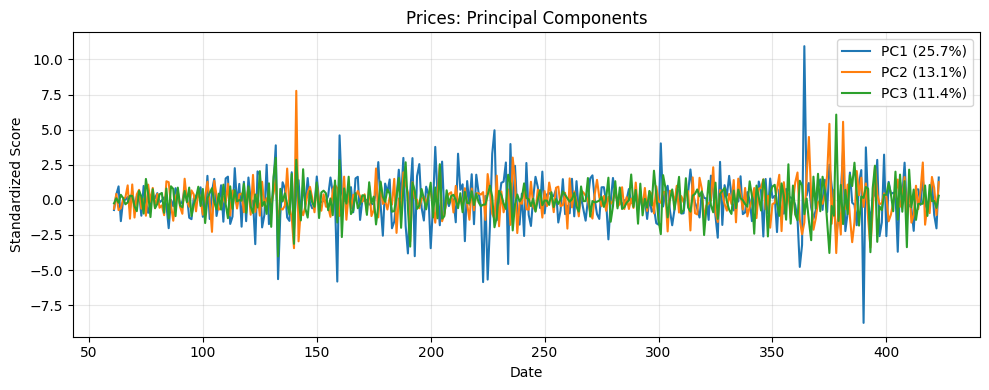

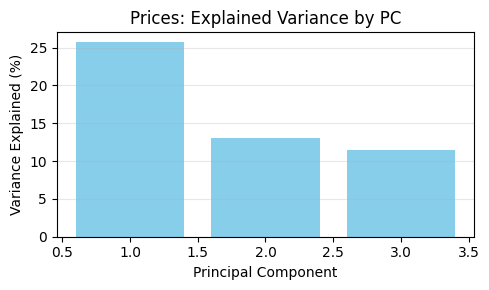

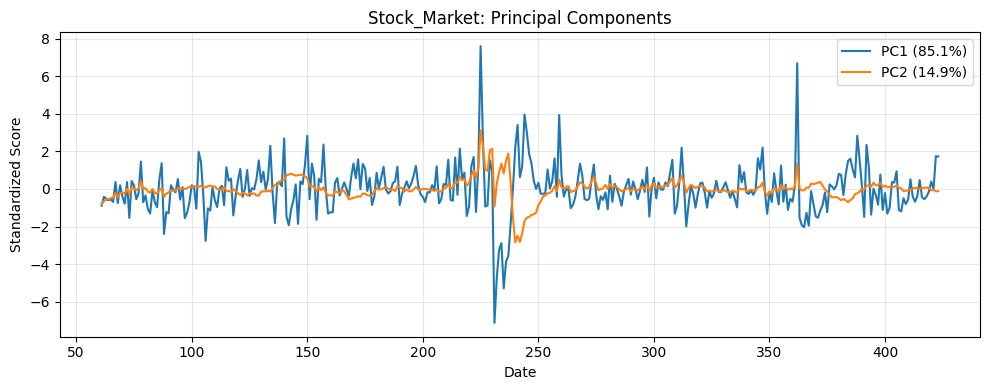

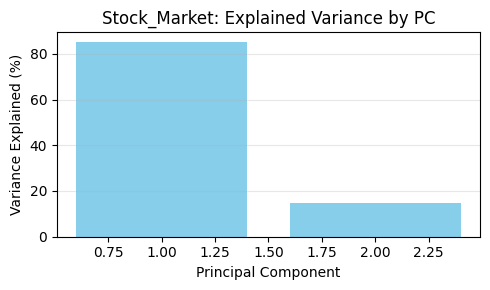

In [209]:
plot_group_pca(pruned_df, groups, n_components=3)


In [210]:
# ----------------------------------
# 2️⃣ PCA ranking + feature selection (multi-PC weighted + importance print)
# ----------------------------------
def get_top_features(df, groups, top_k=4, n_pcs=3):
    """
    Selects top features within each group based on weighted importance 
    across multiple principal components and prints all feature importances.

    Parameters:
    - df: DataFrame containing all features
    - groups: dict {group_name: list_of_columns}
    - top_k: number of top features to select per group
    - n_pcs: number of principal components to consider in weighting
    """
    selected_features = {}
    all_importances = {}

    for name, cols in groups.items():
        existing = [c for c in cols if c in df.columns]
        if not existing:
            print(f"⚠️ Skipping {name}: no matching columns.")
            continue

        X = df[existing].copy()
        if X.isna().all().all():
            print(f"⚠️ Skipping {name}: all NaN.")
            continue

        # Fill missing values with column mean (keeps all rows)
        X = X.fillna(X.mean())

        # Standardize
        X_scaled = StandardScaler().fit_transform(X)

        # Fit PCA
        n_components = min(n_pcs, len(existing))
        pca = PCA(n_components=n_components, random_state=42).fit(X_scaled)

        # -------------------------------
        # Compute feature importance
        # -------------------------------
        variance_weights = pca.explained_variance_ratio_
        loadings = np.abs(pca.components_).T  # shape: [features, components]
        importance = np.dot(loadings, variance_weights)  # weighted sum across PCs

        # Store all importances
        ranking = pd.Series(importance, index=existing).sort_values(ascending=False)
        all_importances[name] = ranking

        # Select top features
        top_features = ranking.head(top_k).index.tolist()
        selected_features[name] = top_features

        # Print results
        print(f"\n{name}: Explained variance (first {n_components} PCs) = {variance_weights.sum()*100:.2f}%")
        print(f"Top {top_k} features → {top_features}\n")
        print(ranking.to_string(float_format=lambda x: f'{x:,.4f}'))

    # Flatten all selected feature lists
    all_top_features = [f for feats in selected_features.values() for f in feats]
    return all_top_features, selected_features, all_importances



top_features, group_dict, all_importances = get_top_features(pruned_df, groups, top_k=5)

# Flatten all features defined in the groups
group_features = [f for cols in groups.values() for f in cols]

# Identify columns not included in any group
unmapped_columns = [col for col in pruned_df.columns if col not in group_features]

# Remove "Date" from the list if it exists
unmapped_columns = [col for col in unmapped_columns if col not in ["Date"]]

print("\n⚠️ Columns not mapped to any group:")
print(unmapped_columns)

top_features = top_features + unmapped_columns

# Remove duplicates while preserving order
top_features = list(dict.fromkeys(top_features))

# Create final DataFrame
top_features_df = pruned_df[top_features].copy()

print("\n✅ Final DataFrame shape:", top_features_df.shape)
print("✅ Columns:\n", top_features_df.columns.tolist())




Output_Income: Explained variance (first 3 PCs) = 76.11%
Top 5 features → ['IPNCONGD', 'INDPRO', 'IPNMAT', 'IPB51222S', 'IPFUELS']

IPNCONGD    0.2828
INDPRO      0.2489
IPNMAT      0.2347
IPB51222S   0.2262
IPFUELS     0.2149
RPI         0.1839
W875RX1     0.1720

Labor_Market: Explained variance (first 3 PCs) = 50.21%
Top 5 features → ['UEMPMEAN', 'USFIRE', 'UEMP27OV', 'UEMP15OV', 'CES0600000008']

UEMPMEAN        0.1406
USFIRE          0.1289
UEMP27OV        0.1225
UEMP15OV        0.1134
CES0600000008   0.1132
USGOVT          0.1129
UEMPLT5         0.1094
UEMP5TO14       0.1055
CLF16OV         0.0978
CES1021000001   0.0967
CES0600000007   0.0929
CES2000000008   0.0891
AWOTMAN         0.0886
CLAIMSx         0.0841
HWI             0.0717
CES3000000008   0.0546

Consumption_Orders: Explained variance (first 1 PCs) = 100.00%
Top 5 features → ['HOUST']

HOUST   1.0000

Orders_Inventories: Explained variance (first 3 PCs) = 73.87%
Top 5 features → ['AMDMUOx', 'ACOGNO', 'DPCERA3M086SBEA',

In [211]:
top_features_df.shape

(363, 48)

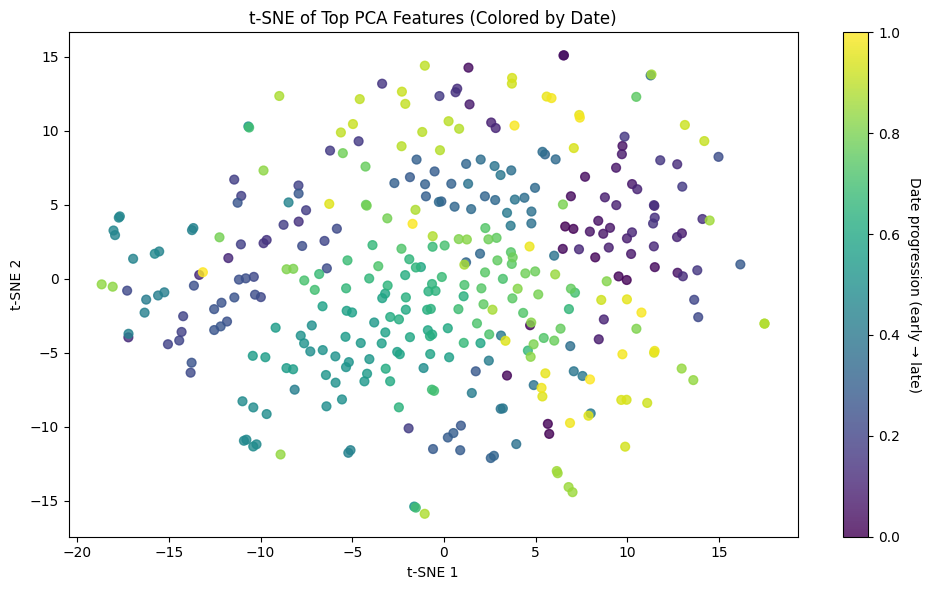

In [212]:
# -----------------------------
# Step 1: Clean & prepare data
# -----------------------------
df = top_features_df.copy()

# Keep only numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# If original merged_df had a Date column, reuse it here
dates = pd.to_datetime(merged_df['Date'])

# Drop rows with NaNs in numeric data (to avoid t-SNE errors)
mask = df_numeric.dropna(axis=0, how='any').index
df_numeric = df_numeric.loc[mask]
dates = dates.loc[mask]

# -----------------------------
# Step 2: Standardize features
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# -----------------------------
# Step 3: Run t-SNE
# -----------------------------
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='random',
    random_state=42
)
X_embedded = tsne.fit_transform(X_scaled)

# -----------------------------
# Step 4: Create t-SNE DataFrame
# -----------------------------
tsne_df = pd.DataFrame({
    'TSNE1': X_embedded[:, 0],
    'TSNE2': X_embedded[:, 1],
    'Date': dates.values
}).sort_values('Date')

# Normalize date for color mapping
date_numeric = (tsne_df['Date'] - tsne_df['Date'].min()) / (
    tsne_df['Date'].max() - tsne_df['Date'].min()
)

# -----------------------------
# Step 5: Plot
# -----------------------------
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    tsne_df['TSNE1'],
    tsne_df['TSNE2'],
    c=date_numeric,
    cmap='viridis',
    s=40,
    alpha=0.8
)
cbar = plt.colorbar(scatter)
cbar.set_label('Date progression (early → late)', rotation=270, labelpad=15)
plt.title('t-SNE of Top PCA Features (Colored by Date)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()


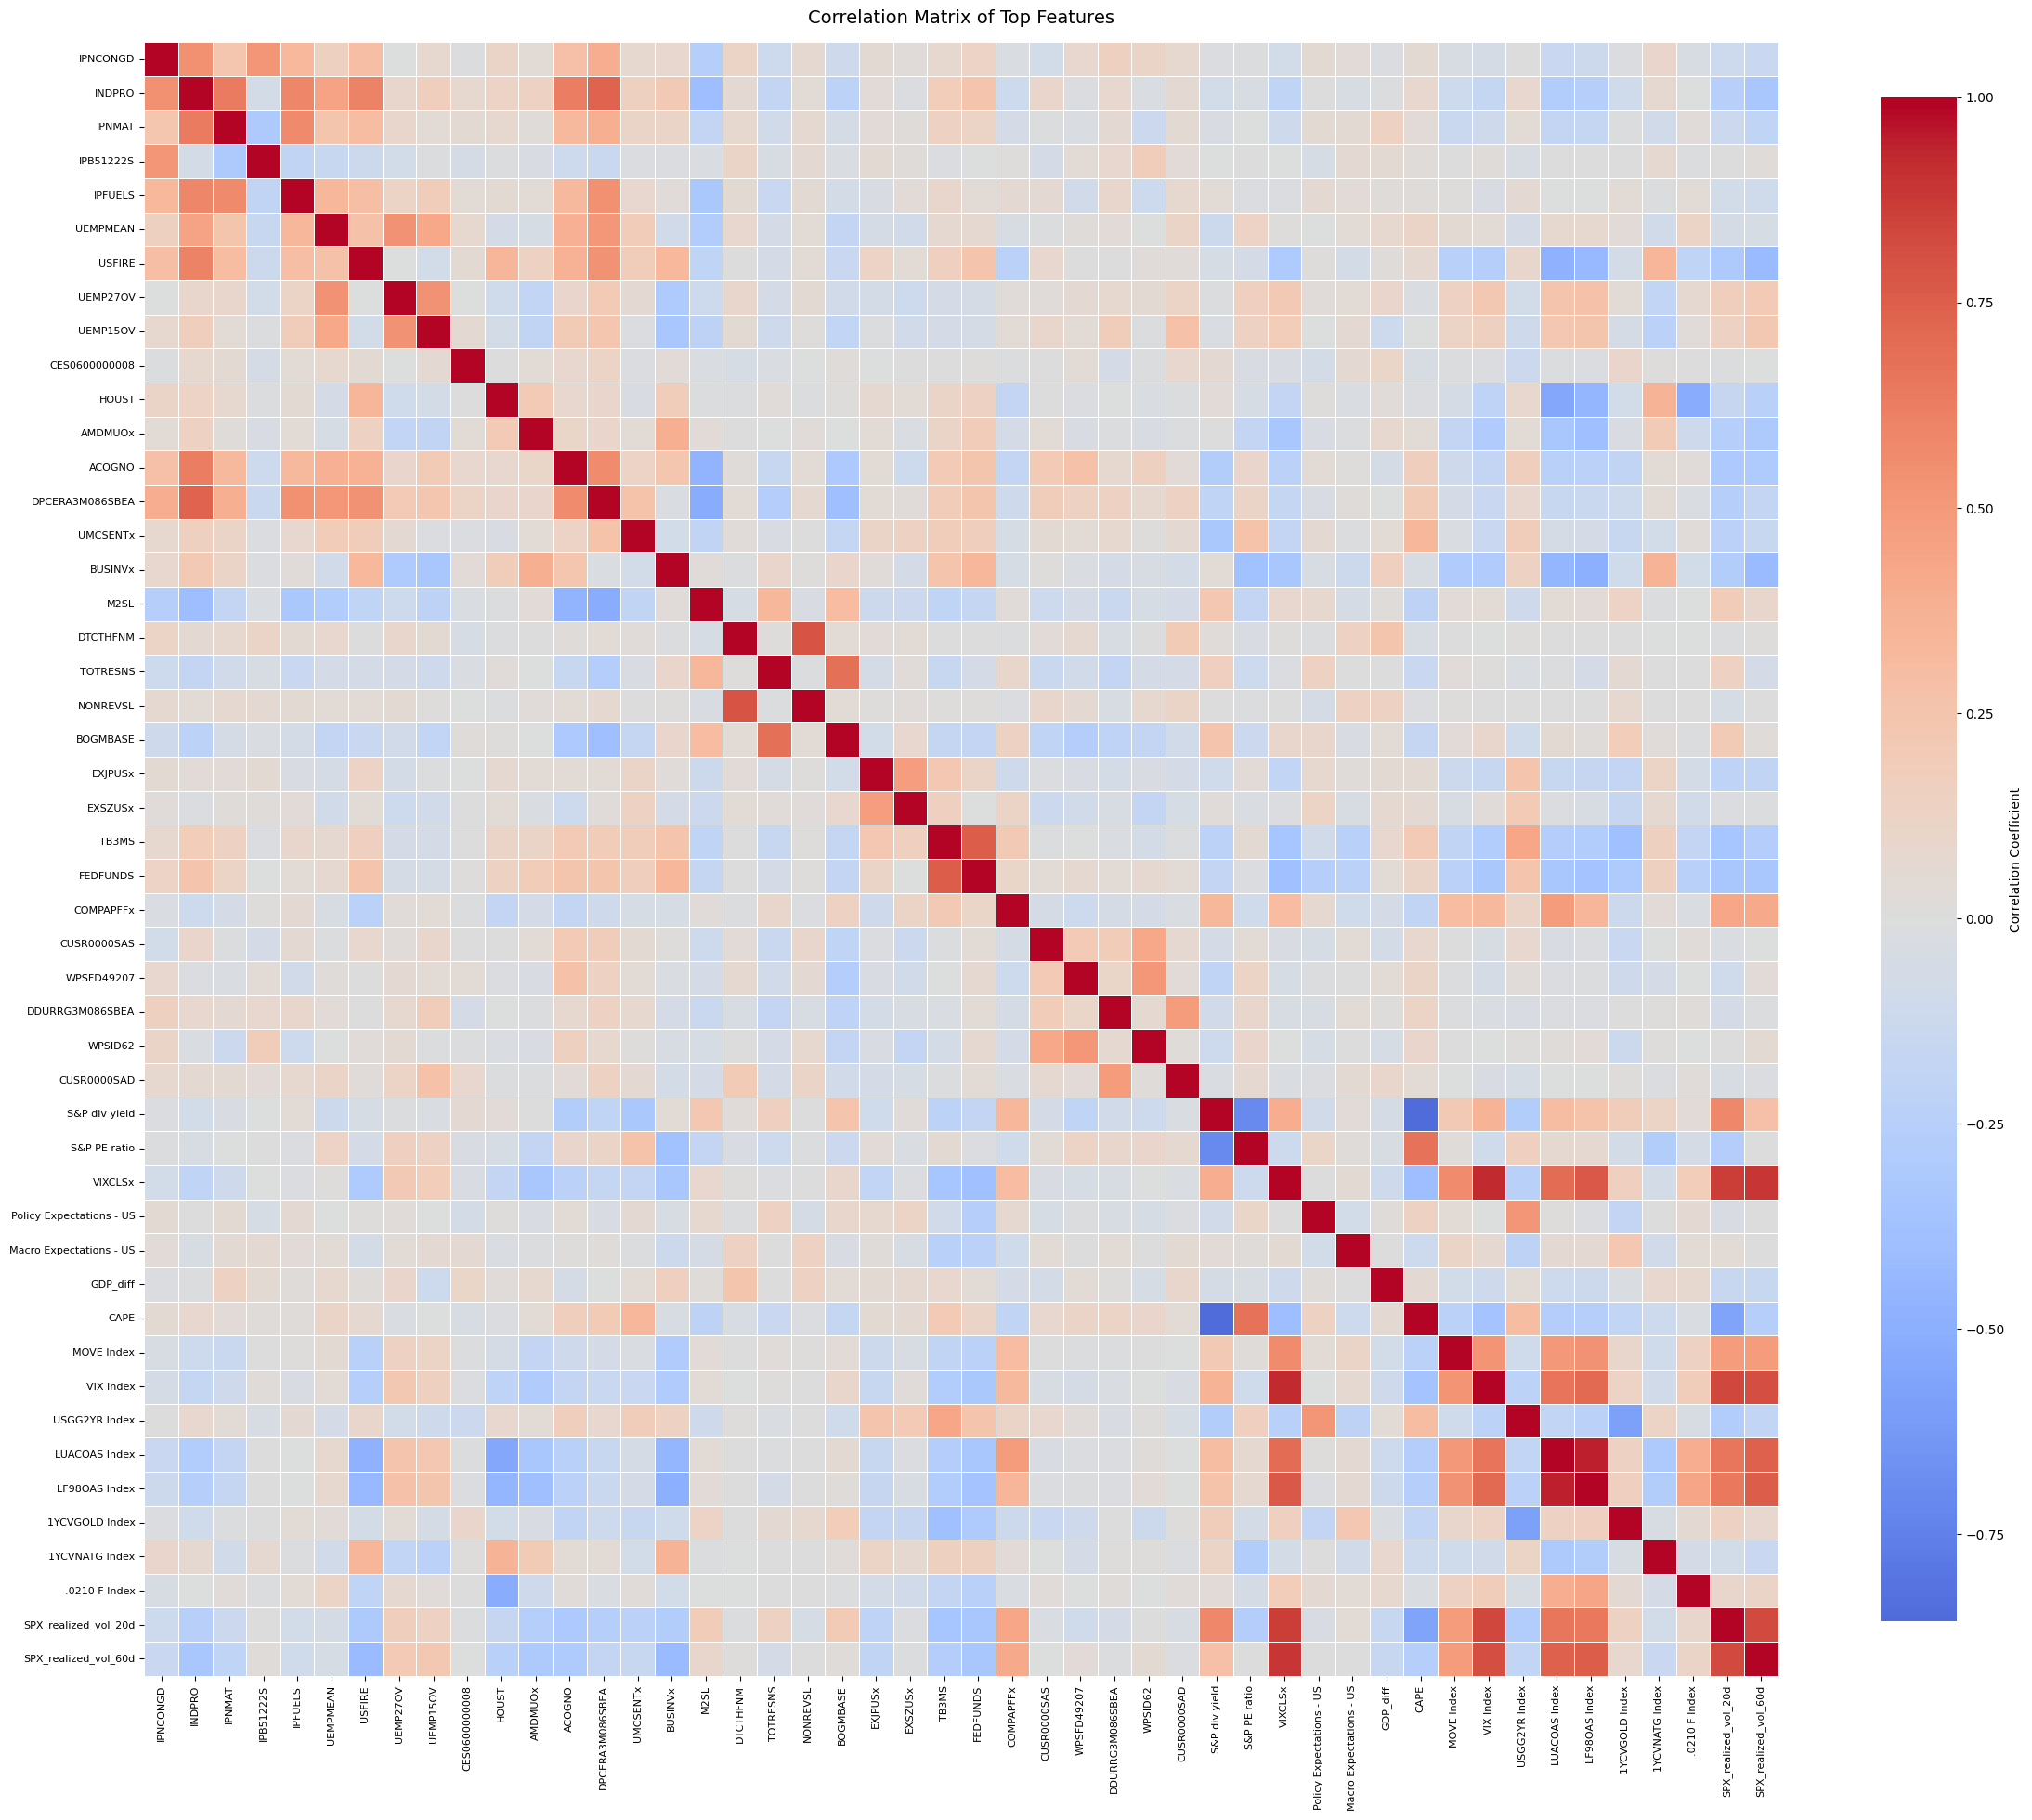

In [213]:

# --- Correlation heatmap for all features ---
plt.figure(figsize=(max(12, 0.5 * len(top_features_df.columns)),   # scale width with #features
                    max(10, 0.5 * len(top_features_df.columns))))  # scale height similarly

sns.heatmap(
    top_features_df.corr(),
    cmap='coolwarm',
    center=0,
    annot=False,
    fmt=".2f",
    linewidths=0.4,
    square=True,
    cbar_kws={'shrink': 0.7, 'label': 'Correlation Coefficient'}
)

plt.title("Correlation Matrix of Top Features", fontsize=14, pad=15)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout(pad=2)
plt.show()


## This method seems to preserve some information while reducing the dimension significantly

In [214]:
columns_to_keep=top_features_df.columns

In [215]:
merged_df=pd.read_csv("merged_dataset_final.csv")

In [216]:
merged_df[["Date",*columns_to_keep]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      428 non-null    object 
 1   IPNCONGD                  427 non-null    float64
 2   INDPRO                    427 non-null    float64
 3   IPNMAT                    427 non-null    float64
 4   IPB51222S                 427 non-null    float64
 5   IPFUELS                   427 non-null    float64
 6   UEMPMEAN                  427 non-null    float64
 7   USFIRE                    427 non-null    float64
 8   UEMP27OV                  427 non-null    float64
 9   UEMP15OV                  427 non-null    float64
 10  CES0600000008             427 non-null    float64
 11  HOUST                     427 non-null    float64
 12  AMDMUOx                   427 non-null    float64
 13  ACOGNO                    400 non-null    float64
 14  DPCERA3M08

In [217]:
merged_df[["Date",*columns_to_keep]].drop(columns=["1YCVGOLD Index","1YCVNATG Index","Policy Expectations - US","Macro Expectations - US","LF98OAS Index","ACOGNO","VIXCLSx"]).dropna().to_csv("top_features_df.csv", index=False)